# Failure Category Cluster using Unsupervised ML
This is the last step before the Machine Learning training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import preprocessing

In [2]:
## Define a window processing function

# result = slide_window_fft(fft_size, data, fs, overlap_fac)
def slide_window_fft(data, fft_size, fs, overlap_fac):
    data = data.flatten()
    hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
    pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
    total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
    t_max = len(data) / np.float32(fs)

    window = np.hanning(fft_size)  # our half cosine window
    inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

    proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
    result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result

    for i in range(total_segments):                      # for each segment
        current_hop = hop_size * i                        # figure out the current segment offset
        segment = proc[current_hop:current_hop+fft_size]  # get the current segment
        windowed = segment * window                       # multiply by the half cosine function
        padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
        spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
        autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
        result[i, :] = autopower[:fft_size]               # append to the results array
    
    result = 20*np.log10(result)          # scale to db
    return result


In [3]:
npzfile = np.load('CWRU_cleaned.npz')
df_time = pd.DataFrame()
df_fft = pd.DataFrame()
category_labels = ['Normal','Ball 0.007 inch', 'Ball 0.014 inch', 'Ball 0.021 inch', 
                  'Inner race 0.007 inch', 'Inner race 0.014 inch', 'Inner race 0.021 inch',
                  'Outer race 0.007 inch', 'Outer race 0.014 inch', 'Outer race 0.021 inch']

res = dict(zip(npzfile.files, category_labels))

#todo first drop na for df_time
#second scale the data after it was done

for fi in npzfile.files:
    # time data 
    df = pd.DataFrame(npzfile[fi], columns=[res[fi]])
#     df['labels'] = res[fi]
    df_time = pd.concat([df_time, df], axis = 1)

df_time.dropna(axis = 0,inplace=True)
df_time_scaled = pd.DataFrame(preprocessing.scale(df_time), columns=df_time.columns)
print(df_time_scaled)


          Normal  Ball 0.007 inch  Ball 0.014 inch  Ball 0.021 inch  \
0       0.519166        -0.429365        -3.376357        -0.352299   
1      -0.757243        -0.465417        -3.463821        -0.236117   
2      -1.560197        -0.337731        -3.053186        -0.142775   
3      -1.489819        -0.124421        -2.313448         0.034972   
4      -0.779636         0.109921        -1.300942         0.178957   
...          ...              ...              ...              ...   
381885  1.283731         1.090849        -0.675353         0.304075   
381886  1.101387         1.951603        -0.826562         0.822422   
381887  0.122487         2.565998        -0.835456         1.320909   
381888 -0.648477         2.786819        -0.872517         1.628739   
381889 -0.539710         2.526941        -0.915508         1.739955   

        Inner race 0.007 inch  Inner race 0.014 inch  Inner race 0.021 inch  \
0                    0.040835              -0.109786               1

In [4]:
fft_size = 4000
fs = 1/48000
overlap_fac = 0.01
freq = 1/(fft_size*fs)*np.linspace(0,fft_size-1,fft_size) # frequency axis

for col in df_time.columns:
    # fft data
    result = slide_window_fft(df_time[col].values, fft_size, fs, overlap_fac)
    df = pd.DataFrame(result, columns=freq)
    df['labels'] = col
    df_fft = pd.concat([df_fft, df], axis = 0)
    
# print(df_fft)

### prepare for PCA

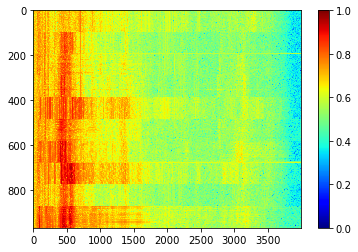

In [5]:
# result = preprocessing.MaxAbsScaler().fit_transform(df_fft.drop('labels',axis = 1).values)
def normalization(xdata, xmax = 0, xmin = 0):

    if xmax == 0:
        xmax = xdata.max()
        xmin = xdata.min()

    data_f = (xdata - xmin)/(xmax - xmin)
    return data_f

result = normalization(df_fft.drop('labels',axis = 1).values)
img = plt.imshow(result, cmap='jet', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

## PCA

In [6]:
fault_type = pd.Categorical(df_fft['labels']).rename_categories(category_labels)

Text(0.5, 1.0, 'Result of PCA without data scaling')

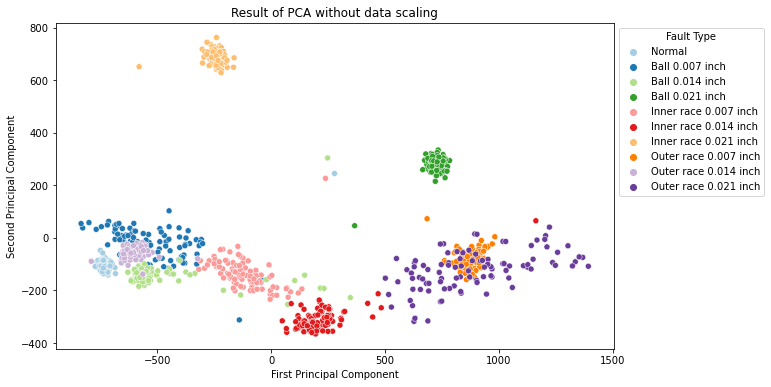

In [7]:
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns
# for time
pca_res = sklearn.decomposition.PCA(n_components= 2, random_state= 1).fit_transform(df_fft.drop('labels',axis = 1))

plt.figure(figsize=(10,6))
sns.scatterplot(
        x=pca_res[:,0], y= pca_res[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(pca_res))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Result of PCA without data scaling")

C:\Users\mrzha\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\mrzha\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Text(0.5, 1.0, 'Result of PCA after data scaling')

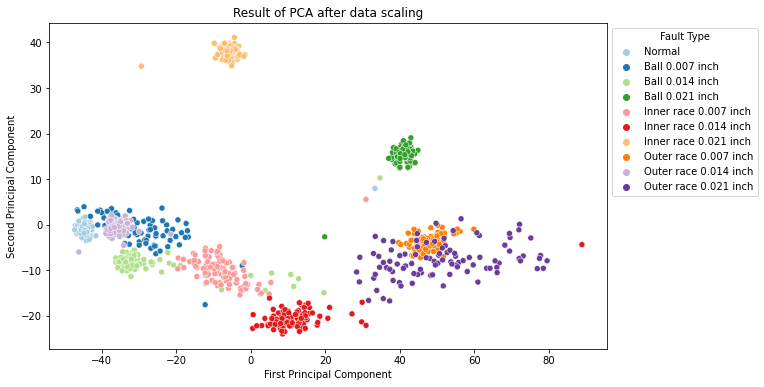

In [8]:
scaled_data = preprocessing.scale(df_fft.drop('labels',axis = 1)) 

pca_scaled_res = sklearn.decomposition.PCA(n_components=2, random_state = 2).fit_transform(scaled_data)
plt.figure(figsize=(10,6))
sns.scatterplot(
        x=pca_scaled_res[:,0], y= pca_scaled_res[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(pca_scaled_res))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Result of PCA after data scaling")

## Kernel PCA

Text(0.5, 1.0, 'Result of KPCA on scaled data')

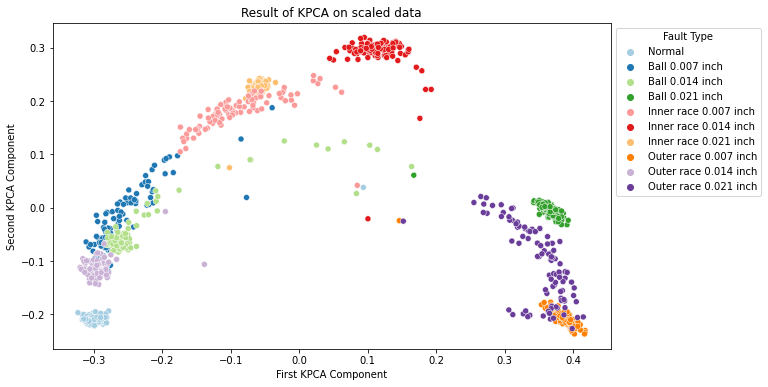

In [9]:
ker_pca_res = sklearn.decomposition.KernelPCA(
    n_components=2,kernel="rbf",gamma = 0.005/fft_size,random_state=3).fit_transform(
    df_fft.drop('labels',axis = 1))

plt.figure(figsize=(10,6))
sns.scatterplot(
        x=ker_pca_res[:,0], y= ker_pca_res[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(ker_pca_res))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First KPCA Component")
plt.ylabel("Second KPCA Component")
plt.title("Result of KPCA on scaled data")

## t-SNE

Text(0.5, 1.0, 'Result of t-SNE on scaled data')

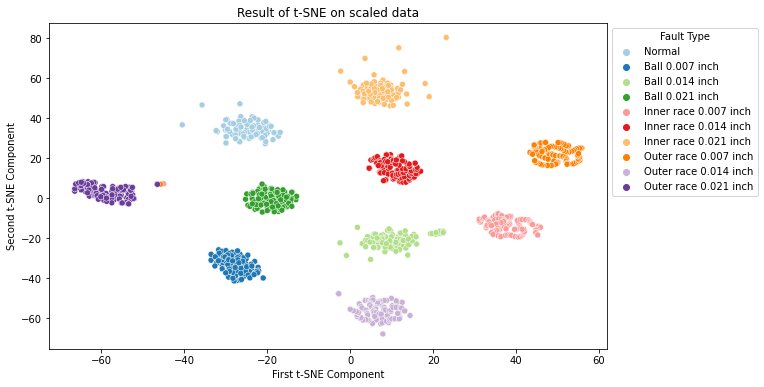

In [61]:
# t-SNE is only good for virtuallization, it does not have the ability learning the mapping function
from sklearn.manifold import TSNE
T_sne_model = TSNE(n_components=2,random_state=4)
tsne_res = T_sne_model.fit_transform( df_fft.drop('labels',axis = 1))
plt.figure(figsize=(10,6))
sns.scatterplot(
        x=tsne_res[:,0], y= tsne_res[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(tsne_res))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First t-SNE Component")
plt.ylabel("Second t-SNE Component")
plt.title("Result of t-SNE on scaled data")

## Autoencoder (Neuron Network)

In [119]:
# definition of Autoencoder
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential, layers
import os
from functools import partial

h_dim = 2
Data_Size = fft_size

class auto_encoder(keras.Model):

    def __init__(self):
        super(auto_encoder, self).__init__()

        # Encoders
        self.encoder = Sequential([
#             layers.Dense(4000, activation=tf.nn.relu),
            layers.Dense(1024, activation=partial(tf.nn.leaky_relu, alpha =0.1) ),
            layers.Dense(512, activation=partial(tf.nn.leaky_relu, alpha =0.1)),
            layers.Dense(64, activation= partial(tf.nn.leaky_relu, alpha =0.1)),
            layers.Dense(16, activation= partial(tf.nn.leaky_relu, alpha =0.1)),
            layers.Dense(4, activation= partial(tf.nn.leaky_relu, alpha =0.1)),
            layers.Dense(h_dim)
        ])

        # Decoders
        self.decoder = Sequential([
            layers.Dense(4, activation=partial(tf.nn.leaky_relu, alpha =0.1)),
            layers.Dense(16, activation=partial(tf.nn.leaky_relu, alpha =0.1)),
            layers.Dense(64, activation=partial(tf.nn.leaky_relu, alpha =0.1)),
            layers.Dense(512, activation=partial(tf.nn.leaky_relu, alpha =0.1)),
            layers.Dense(1024, activation=partial(tf.nn.leaky_relu, alpha =0.1)),
#             layers.Dense(4000, activation=tf.nn.relu),
            layers.Dense(Data_Size)
        ])    

    def call(self, inputs, training=None):
        h = self.encoder(inputs)
        x_hat = self.decoder(h)
        return x_hat
    
    def home_define_fit(self, x, n_epoch, optimizer, flag_save_weight):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        rec_loss = 0
        q_flag = False
#         reduced_lr = optimizer.learning_rate*0.2
        for epoch in range(n_epoch):
            with tf.GradientTape() as tape:
                x_rec_logits = self.call(x)
                rec_loss = tf.keras.losses.MSE(x, x_rec_logits)
                rec_loss = tf.reduce_mean(rec_loss)
                # adding regulartion
#                 loss_regularization = []
#                 for p in self.trainable_variables:
#                     loss_regularization.append(tf.nn.l2_loss(p))
#                 loss_regularization = tf.reduce_sum(tf.stack(loss_regularization))
#                 rec_loss = rec_loss + 0.0001 * loss_regularization


            grads = tape.gradient(rec_loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
#             if epoch % 50 == 0:
#                 with train_summary_writer.as_default():
#                     tf.summary.scalar('loss', float(rec_loss), step=epoch)


#             if epoch > 200 == 0 and not q_flag:
#                 optimizer.learning_rate = reduced_lr
#                 rec_loss_pre = rec_loss
        
            if epoch % 500 == 0:
                print(epoch, 'rec loss:', float(rec_loss))
            
        print('finnal rec loss:', float(rec_loss))
        
        if flag_save_weight:
            if not os.path.exists('ModelSave'):
              # Create a new directory because it does not exist 
              os.makedirs('ModelSave')
                
            self.save_weights('ModelSave\AE_Vibmon.ckpt')


In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# data normalization
df_fft_np = normalization(df_fft.drop('labels',axis = 1).values)

# data split
train_data, test_data, train_labels, test_labels = train_test_split(df_fft_np, df_fft['labels'], 
                                                                    test_size = 0.1, random_state = 42,
                                                                   stratify = df_fft['labels'])
# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

(873, 4000) (873,) (97, 4000) (97,)


In [121]:
# fit the model
auto_coder1 = auto_encoder()
auto_coder1.build(input_shape=(None, fft_size))
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
# auto_coder1.compile(loss = 'MSE', optimizer = opt, metrics= ['MSE'])
auto_coder1.home_define_fit(df_fft_np, 5000, opt, 1)

0 rec loss: 0.36234310269355774
500 rec loss: 0.0015369978500530124
1000 rec loss: 0.0015331918839365244
1500 rec loss: 0.0015425344463437796
2000 rec loss: 0.0014089023461565375
2500 rec loss: 0.0014014282496646047
3000 rec loss: 0.0014280180912464857
3500 rec loss: 0.0013671987690031528
4000 rec loss: 0.0014233591500669718
4500 rec loss: 0.0013501333305612206
finnal rec loss: 0.0013508702395483851


In [137]:
# try different converging method and bring the loss down to certain level
opt = tf.keras.optimizers.Adam(learning_rate=0.00002)
auto_coder1.home_define_fit(df_fft_np, 5000, opt, 1)

0 rec loss: 0.0009491847013123333
500 rec loss: 0.0009485392947681248
1000 rec loss: 0.0009482305613346398
1500 rec loss: 0.0009480562875978649
2000 rec loss: 0.0009473647805862129
2500 rec loss: 0.0009470994700677693
3000 rec loss: 0.0009462432935833931
3500 rec loss: 0.0009458069689571857
4000 rec loss: 0.0009452701197005808
4500 rec loss: 0.000944808591157198
finnal rec loss: 0.0009441873407922685


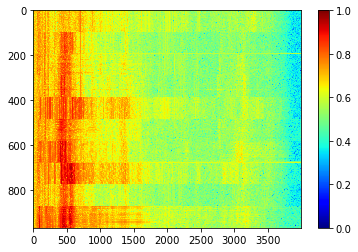

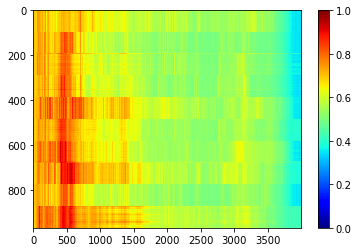

In [138]:
# plotting of Autoencoder
encoded_imgs = auto_coder1.encoder(df_fft_np).numpy()
decoded_imgs = auto_coder1.decoder(encoded_imgs).numpy()

img = plt.imshow(df_fft_np, cmap='jet', interpolation='nearest', aspect='auto',vmax = 1.0, vmin = 0.0)
plt.colorbar()
plt.show()

img = plt.imshow(decoded_imgs, cmap='jet', interpolation='nearest', aspect='auto',vmax = 1.0, vmin = 0.0)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Result of AutoEncoder on scaled data')

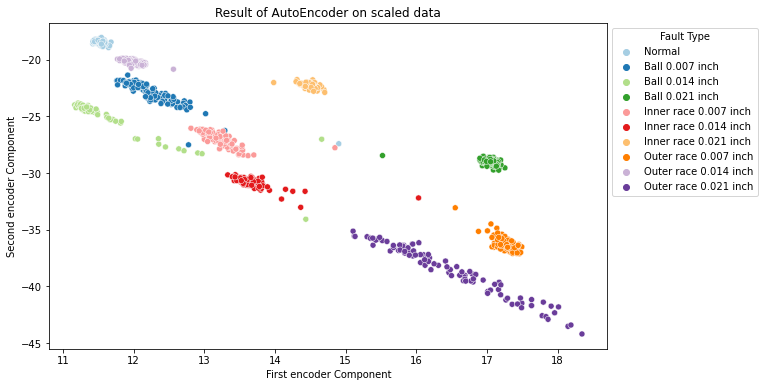

In [139]:
plt.figure(figsize=(10,6))
sns.scatterplot(
        x=encoded_imgs[:,0], y= encoded_imgs[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(encoded_imgs))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First encoder Component")
plt.ylabel("Second encoder Component")
plt.title("Result of AutoEncoder on scaled data")